# Пример bootstrap на синтетических данных

### Полезные ссылки:
- <a href="https://numpy.org/">Numpy documentation</a><br />
- <a href="https://pandas.pydata.org/">Pandas documentation</a><br />
- <a href="https://matplotlib.org/">Matplotlib documentation</a><br />
- <a href="https://scikit-learn.org/stable/">sklearn documentation</a><br />

### Дополнительные материалы:
- Лекция М.А. Криницкого про Bootstrap (ML4ES): [видео](https://ml4es.ru/links/ML4ES-2022-Lect09), [ноутбук](https://github.com/MKrinitskiy/ML4ES1-F2022-S2023/blob/main/Lect09/LR_problem-uncertainties-Bootstrap.ipynb)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline 
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150

## Генерация данных 

Порождаем синтетические данные с зависимость y от x в форме многочлена 3-й степени. Для этого используем модель препроцессинга [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) библиотеки sklearn. 

X shape:  (1000, 1)
X_poly shape:  (1000, 4)


,0
0,-9.543789
1,-9.970516
2,-9.896997
3,-10.195069
4,-9.903825


,0,1,2,3
0,1.0,-9.543789,91.083907,-869.285585
1,1.0,-9.970516,99.411183,-991.180753
2,1.0,-9.896997,97.950546,-969.416244
3,1.0,-10.195069,103.939433,-1059.669691
4,1.0,-9.903825,98.085748,-971.424069


(-10.0, 10.0)

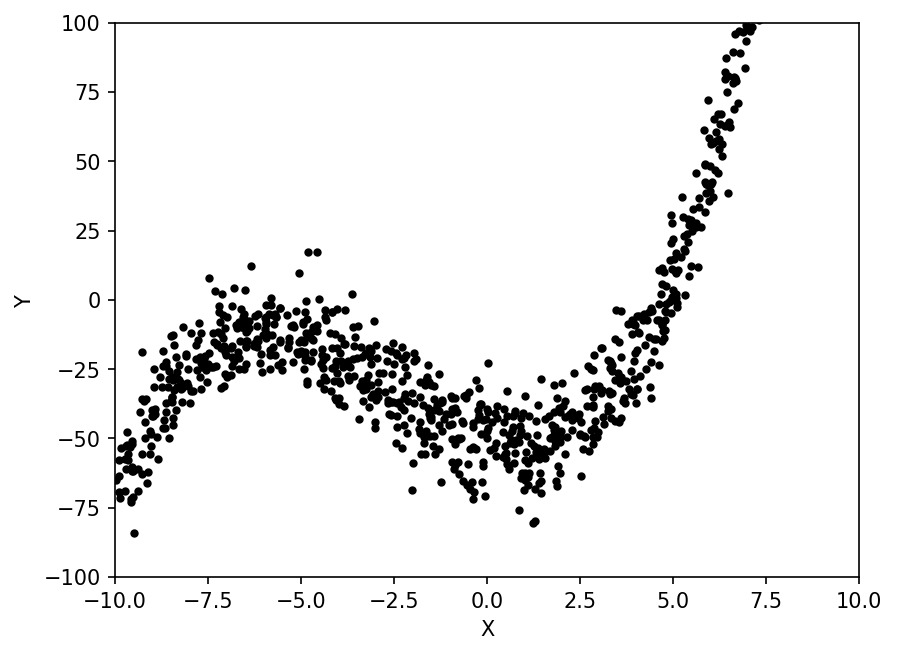

In [3]:

true_degee = 3; true_theta = [-50, -4, 1.9, 0.25]
#true_degee = 4; true_theta = [0, -2.5, -1.9, -0.019, 0.021]

true_noise = 10
    

def generate_data (sample_size = 40):
    
    X = np.linspace(-10, 10, sample_size) + np.random.randn(sample_size)*0.25
    X = X.reshape(-1,1)

    poly = PolynomialFeatures(true_degee)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    print('X shape: ', X.shape)
    print('X_poly shape: ', X_poly.shape)

    display(pd.DataFrame (X).head())
    display(pd.DataFrame (X_poly).head())

    Y = np.dot(X_poly, true_theta) + np.random.randn(sample_size) * true_noise  #+ np.random.randn(sample_size) * np.sqrt (np.abs(X)) * 2
    Y = Y.reshape(-1,1)
    return X, Y

X, Y = generate_data (1000)

plt.figure()
plt.plot(X, Y, '.k')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim([-100, 100])
plt.xlim([-10, 10])


## Создаем новый класс моделей машинного обучения - полиномиальную регрессию

Данная модель объединяет модель линейной регресии [LinearRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html), модель порождения полиномиальных признаков   [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) и, опционально, произвольную модель масштабирования данных.  

Модель имеет два **гиперпараметра**:
- Степень полинома
- Модель масштабирования данных (по умолчанию отсутствует)

In [4]:
class PolynomialRegression:
    def __init__(self, degree = 1, scaler = None):
        self.degree = degree
        self.regressor = LinearRegression(fit_intercept=False)
        self.scaler = scaler () if scaler is not None else None
        
    def fit(self, X, Y):
        self.poly = PolynomialFeatures(self.degree, include_bias = True)
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        if self.scaler is not None:
            X_poly = self.scaler.fit_transform(X_poly)
        self.regressor.fit(X_poly, Y)
        
    def predict(self, X):
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        if self.scaler is not None:
            X_poly = self.scaler.transform(X_poly)       
        return self.regressor.predict(X_poly)

# Виды неопределенности аппроксимированой целевой переменной
### Алеаторическая неопределенность
Алеаторическая - неопределенность, наследуемая из неопределенности в данных. В рассматриваемой модели линейной регрессии алеаторической неопределенности соответствует ошибка, наследуемая от шума $\epsilon \sim \mathcal{N}(0, \sigma^2)$<br />
Алеаторическую неопределенность **невозможно снизить**. Это базовое свойство той закономерности, которая порождает данные. Можно рассматривать другую закономерность (другую постановку задачи, другой дизайн эксперимента). Но это будет уже другая задача, другая история.

### Эпистемическая неопределенность
Эпистемическая - неопределенность, обусловленная недостаточносностью знаний, сведений, способностей модели, *etc*. В рассматриваемой модели линейной регрессии эпистемической соответствует неопределенность, обусловленная чувствительностью модели к выбросам, надостаточной выразительностью модели, недостаточной обобщающей способностью модели, плохим балансом между обобщающей способностью и выразительностью модели, малым количеством данных.
Эпистемическую неопределенность можно и нужно снижать. Среди путей снижения эпистемической неопределенности в задаче регрессии:

- Увеличение выборки (data mining);
- Фильтрация выбросов в данных (предобработка данных);
- Отбор вида модели: выбор модели, менее чувствительной к выбросам в данных, обладающей лучшей обобщающей способностью, обладающей лучшей выразительностью; правильный подбор гиперпараметров, отвечающих за баланс между обобщающей способностью и выразительностью модели;

### Помимо оценки качества "финальной" модели обязательно нужно оценивать эпистемическую неопределенность
Именно эта неопределенность характеризует, насколько хорошо подходит эта модель для описания имеющихся данных.

Ошибка (качество) модели - оценивается на тестовой выборке. В оценке ошибки модели заложены оба типа неопределенности. Оценка качества модели по какой-то мере качества (например, MSE) - это оценка ошибки **одного** варианта модели, оптимизированного на **конкретной** тренировочной выборке.

**Идеальная модель** имеет ошибку, совпадающую с алеаторичской неопределенностью (шумом в данных, $\epsilon$).

<b>НО!!!</b><br />
В настоящий момент НЕТ простого способа разделить алеаторическую и эпистемическую неопределенности.<br />
Способы разделения этих неопределенностей - открытая область исследований. Наиболее продвинутые результаты получены с применением байесовских подходов (не рассматриваются в этом курсе)


## Bootstrap (бутстрэп, бутстреп)

**Bootstrap** - метод сэмплирования из выборки, предоставляющий возможность оценивать статистики на сокращенной выборке.

**Bootstrap** - метод сэмплирования с возвратом:

1. Определиться с размером bootstrap-выборки $N_b$
2. Повторять до тех пор, пока размер bootstrap-выборки не достигнет $N_b$:
    - Выбрать произвольный элемент исходной выборки, "вернуть" его на место.
    - Добавить выбранный элемент в bootstrap-выборку.


## Оценка качества модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку. Оставшиеся события - т.н. out-of-bag выборка (OOB)<br />
    b. Оптимизировать модель на этой выборке как на тренировочной<br />
    c. Оценить качество модели по выбранной мере качества на OOB-выборке.<br />
4. Оценить качество модели как среднее оценок, получаемых в п.**3.c.**

Получаемая таким образом оценка ошибки включает алеаторическую и эпистемическую неопределенности.

## Оценка значений и неопределенностей параметров модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку.<br />
    b. Оптимизировать модель на этой выборке как на тренировочной, записать полученные параметры.<br />
4. Оценить значения параметров модели как выборочную оценку среднего для параметров, получаемых в п.**3.b.**
5. Оценить неопределенность параметров модели как выборочную оценку стандартного отклонения параметров, получаемых в п.**3.b.**

## Оценка неопределенности вывода модели с применением подхода Bootstrap
1. Определиться с размером bootstrap-выборки $N_b$
2. Определиться с количеством bootstrap-выборок $B$
3. Для каждой bootstrap-выборки:<br />
    a. Получить bootstrap-выборку<br />
    b. Оптимизировать модель на этой выборке как на тренировочной. Записать значения параметров.<br />
4. На новых элементах, к которым следует применить модель, оценивать эпистемическую неопределенность модели следующим образом:
    a. Применить модель в новому объекту с каждым из наборов параметров модели, полученных на этапе **3.b**. ВНИМАНИЕ! Эти значения - аппроксимация целевой переменной **без учета шума $\epsilon$**. То есть, это оценка среднего значения $y_i = \theta\bar{x_i}$ <br/>
    b. Если есть обоснованные предположения относительно параметров распределения шума $\epsilon$ - к каждому значению полученного среднего следует добавить шум.
    b. Оценить неопределенность полученных значений как выборочную оценку стандартного отклонения.

## Программная реализация Bootstrap своими руками

In [5]:
def sample_bootstrap(X, Y, sample_size, return_OOB_sample):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], Y[sample_indices, :], X[oob_indices, :], Y[oob_indices, :]
    else:
        return X[sample_indices, :], Y[sample_indices, :]

## Оценка неопределенности параметров модели и метрик качества

In [6]:
B = 1000
sample_size = 800
model_theta = []
model_quality = []

for i in tqdm(range(B), total=B):
    X_train, Y_train, X_test, Y_test = sample_bootstrap(X,Y, sample_size=sample_size, return_OOB_sample=True)
    model = PolynomialRegression(degree=3) #, scaler=StandardScaler)
    model.fit(X_train,Y_train)
    Y_test_predicted = model.predict(X_test)
    model_quality.append(np.sqrt (mean_squared_error(Y_test, Y_test_predicted)))
    model_theta.append(np.copy(model.regressor.coef_))

model_theta = np.array(model_theta).squeeze()
display(model_theta)

100%|██████████| 1000/1000 [00:07<00:00, 131.80it/s]


array([[-49.7424254 ,  -4.02704057,   1.89680751,   0.25092637],
       [-50.56483374,  -4.05333547,   1.90534348,   0.25033774],
       [-50.46973776,  -4.0060456 ,   1.90312663,   0.25056702],
       ...,
       [-49.55268113,  -3.84240529,   1.90958625,   0.24767969],
       [-50.75459514,  -3.94355408,   1.92525006,   0.24925145],
       [-50.24543115,  -4.10747708,   1.90086693,   0.25193391]])

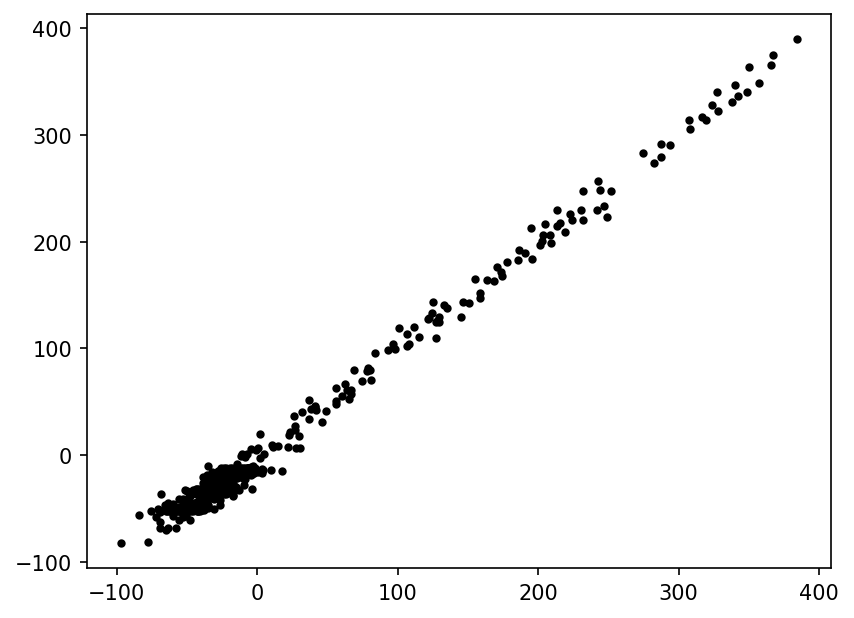

In [7]:
plt.figure()
plt.plot(Y_test, Y_test_predicted, '.k')

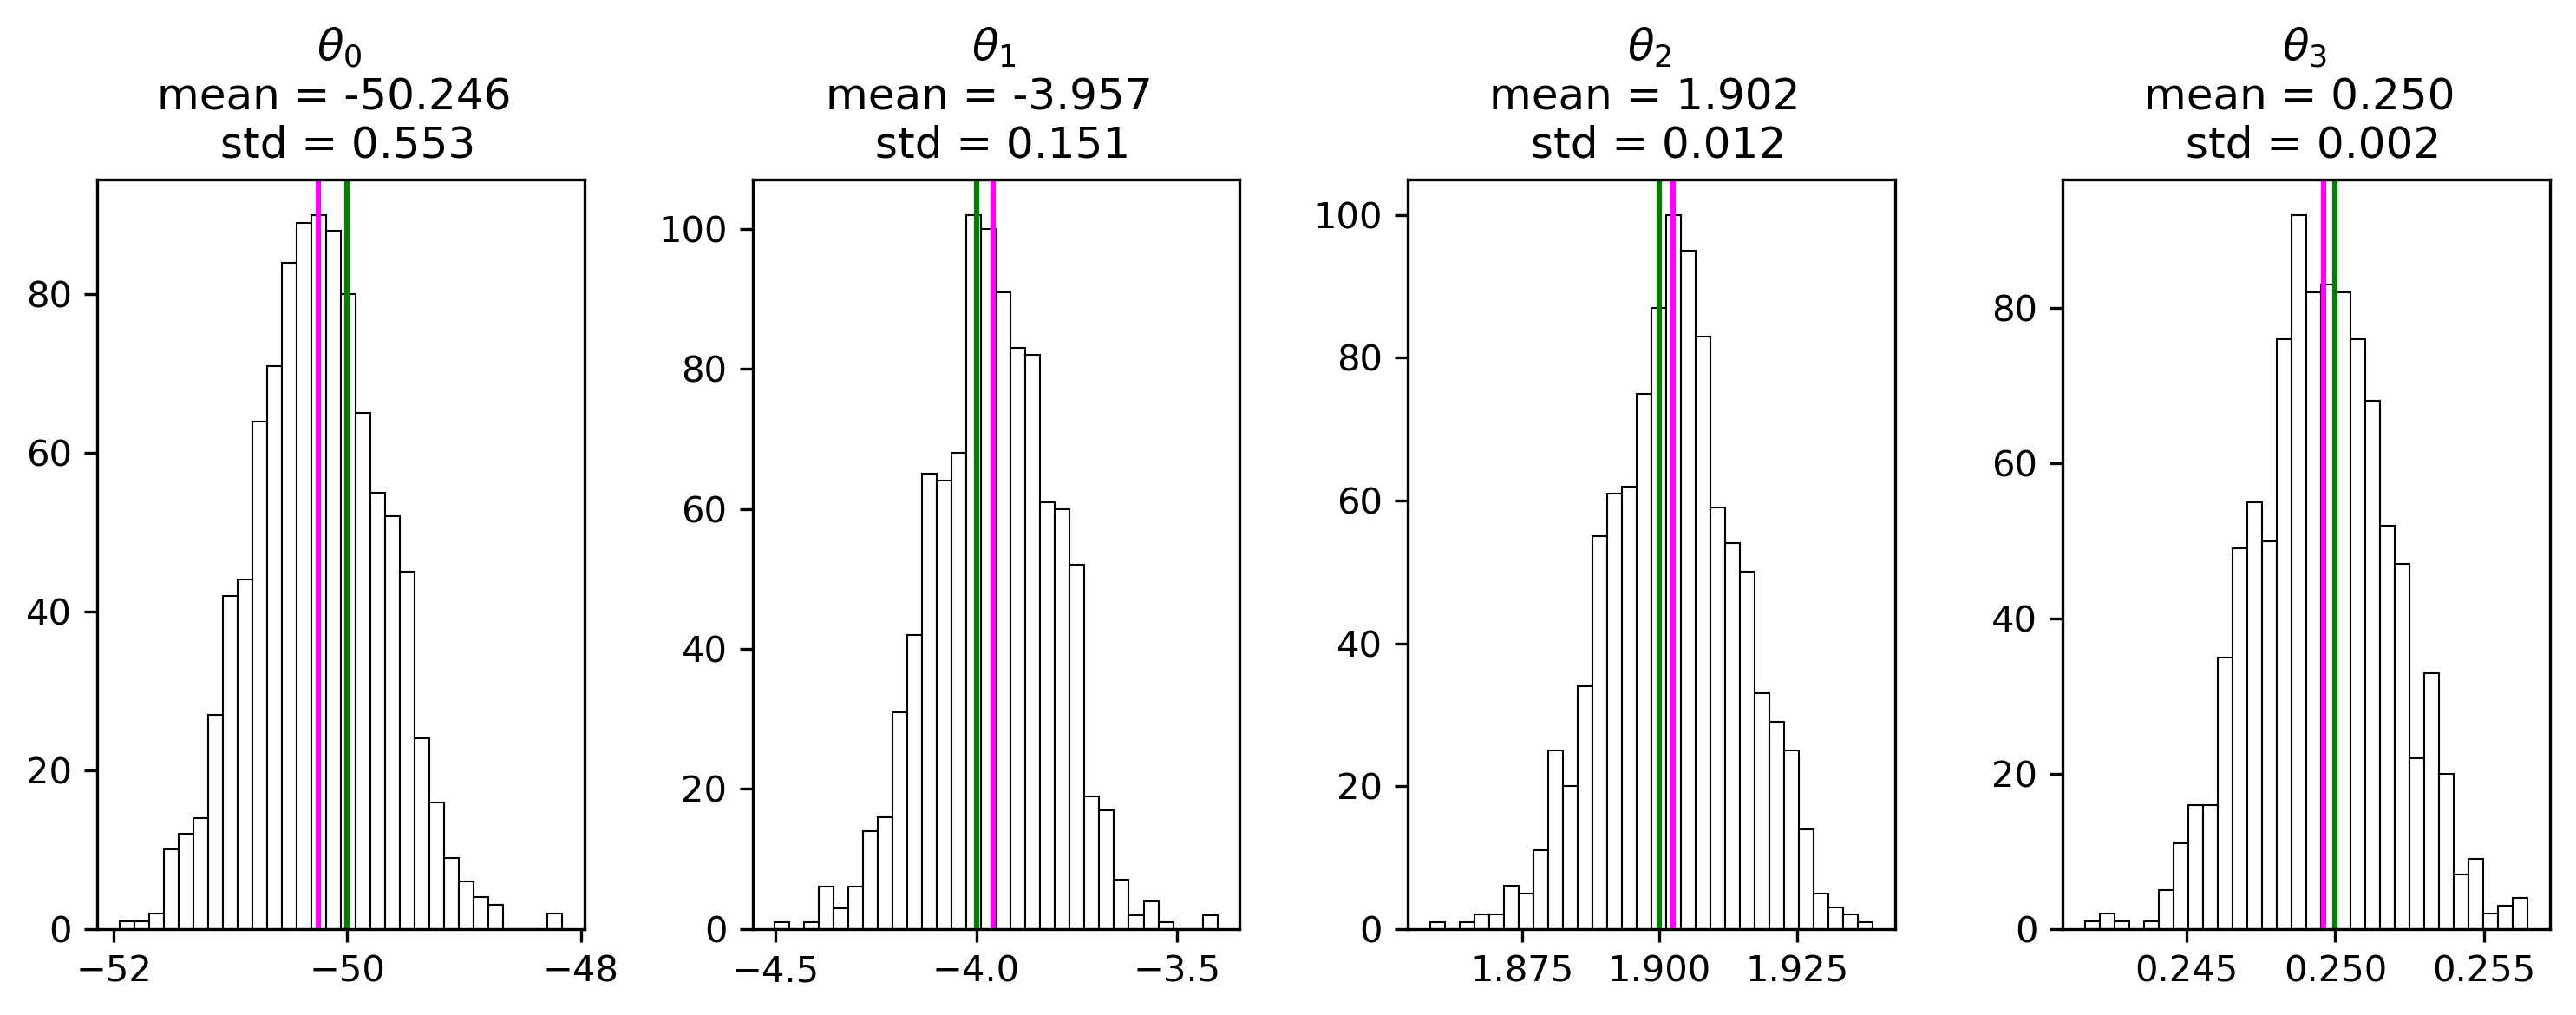

In [8]:
f = plt.figure(figsize=(10,4), dpi=300)
for i in range(model_theta.shape[1]):
    plt.subplot(1,4, i+1)
    h_counts,h_bins,_ = plt.hist(model_theta[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    mean_theta_i = np.mean(model_theta[:,i])
    std_theta_i = np.std(model_theta[:,i])
    y_lim = plt.ylim()
    
    plt.vlines(mean_theta_i,  y_lim[0], y_lim[1], color='magenta')
    plt.vlines(true_theta[i], y_lim[0], y_lim[1], color='green')
    plt.ylim(y_lim)
    plt.title("$\\theta_%d$ \nmean = %.3f \n std = %.3f" % (i, mean_theta_i, std_theta_i))
    
_ = plt.tight_layout()

Text(0.5, 1.0, 'RMSE \nmean = 10.060 \n std = 0.245')

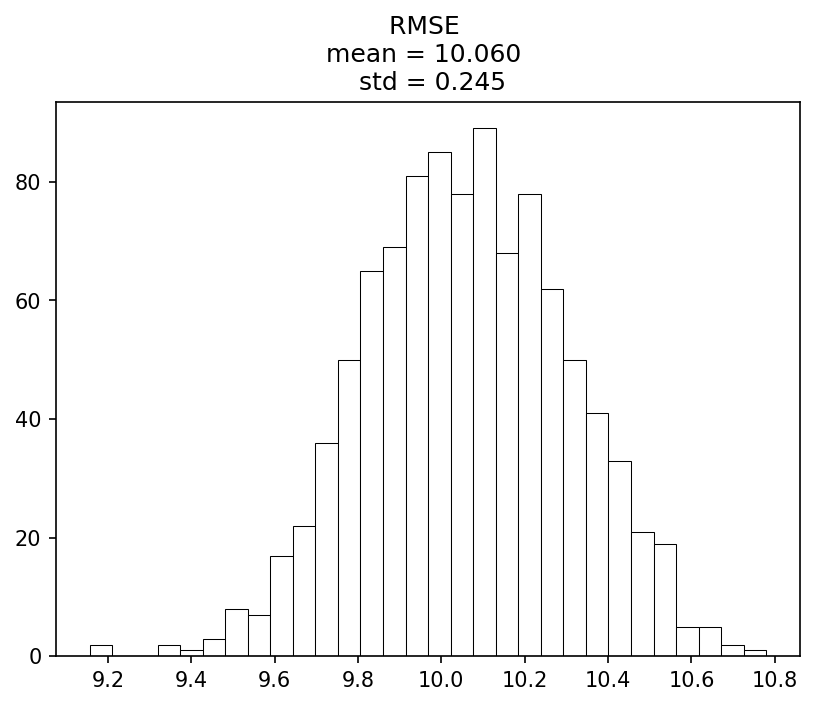

In [10]:
h_counts,h_bins,_ = plt.hist(model_quality, bins=30, color='white', ec="black", linewidth=0.5)
plt.title("RMSE \nmean = %.3f \n std = %.3f" % (np.mean(model_quality), np.std(model_quality)))